# Import necessary packages & data

In [3]:
!pip install geopandas

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import folium
import json
from folium.plugins import HeatMap
from shapely.geometry import MultiPoint, Point

In [5]:
df = pd.read_csv('Access_to_Everyday_Life_Dataset.csv')

In [6]:
df.head()

type geometry/type  geometry/coordinates/0  geometry/coordinates/1  \
0  Feature         Point             -122.298981               47.594616   
1  Feature         Point             -122.301071               47.593357   
2  Feature         Point             -122.301079               47.596844   
3  Feature         Point             -122.301071               47.596500   
4  Feature         Point             -122.306274               47.599930   

   properties/attribute_id properties/label_type properties/neighborhood  \
0                 52096165        SurfaceProblem                Atlantic   
1                 52096166        SurfaceProblem                Atlantic   
2                 52096167        SurfaceProblem                Atlantic   
3                 52096168        SurfaceProblem                Atlantic   
4                 52096365            NoCurbRamp                Atlantic   

   properties/severity  properties/is_temporary  
0                  4.0                    False  
1                  3.0                    False  
2                  4.0                    False  
3                  4.0                    False  
4                  4.0                    False

# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81973 entries, 0 to 81972
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     81973 non-null  object 
 1   geometry/type            81973 non-null  object 
 2   geometry/coordinates/0   81973 non-null  float64
 3   geometry/coordinates/1   81973 non-null  float64
 4   properties/attribute_id  81973 non-null  int64  
 5   properties/label_type    81973 non-null  object 
 6   properties/neighborhood  81973 non-null  object 
 7   properties/severity      79722 non-null  float64
 8   properties/is_temporary  81973 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 5.1+ MB


In [9]:
df['properties/severity'].isna().sum()

2251

Severity column missing data

Rename lat/lon columns

In [12]:
df.rename(columns = {'geometry/coordinates/0':'lon','geometry/coordinates/1':'lat', 'properties/attribute_id':'att_id', 
                     'properties/label_type':'label','properties/neighborhood':'neighborhood','properties/severity':'severity',
                    'properties/is_temporary':'is_temp'},inplace = True)

In [13]:
df.head()

type geometry/type         lon        lat    att_id           label  \
0  Feature         Point -122.298981  47.594616  52096165  SurfaceProblem   
1  Feature         Point -122.301071  47.593357  52096166  SurfaceProblem   
2  Feature         Point -122.301079  47.596844  52096167  SurfaceProblem   
3  Feature         Point -122.301071  47.596500  52096168  SurfaceProblem   
4  Feature         Point -122.306274  47.599930  52096365      NoCurbRamp   

  neighborhood  severity  is_temp  
0     Atlantic       4.0    False  
1     Atlantic       3.0    False  
2     Atlantic       4.0    False  
3     Atlantic       4.0    False  
4     Atlantic       4.0    False

In [14]:
df['type'].value_counts()

type
Feature    81973
Name: count, dtype: int64

In [15]:
df['geometry/type'].value_counts()

geometry/type
Point    81973
Name: count, dtype: int64

Are all att_id values unique?

In [17]:
len(df['att_id'])/len(df)

1.0

## Joining OG data with GEOJSON file of more specific neighborhoods

In [21]:
# 2. Load the GeoJSON file
neighborhoods_gdf = gpd.read_file('Neighborhood_Map_Atlas_Neighborhoods.geojson')

# 3. Convert your DataFrame into a GeoDataFrame
# We create a 'geometry' column using the longitude and latitude
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
incidents_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the Coordinate Reference System (CRS)
# GeoJSON snippet uses 'CRS84' (EPSG:4326): standard Lat/Lon
incidents_gdf.set_crs(epsg=4326, inplace=True)
neighborhoods_gdf.to_crs(epsg=4326, inplace=True)

# 5. Perform the Spatial Join
# This checks which neighborhood polygon each incident point "intersects"
# We only bring over 'S_HOOD' (Specific Neighborhood) and 'L_HOOD' (Larger Region)
joined_df = gpd.sjoin(
    incidents_gdf, 
    neighborhoods_gdf[['S_HOOD', 'L_HOOD', 'geometry']], 
    how='left', 
    predicate='intersects'
)

# 6. Final Clean up
# Rename 'S_HOOD' to 'neighborhood_accurate' and remove the geometry column if no longer needed
joined_df = joined_df.rename(columns={'S_HOOD': 'neighborhood_accurate'})
df_final = pd.DataFrame(joined_df.drop(columns='geometry'))

print(df_final[['lon', 'lat', 'neighborhood_accurate']].head())

          lon        lat neighborhood_accurate
0 -122.298981  47.594616              Atlantic
1 -122.301071  47.593357              Atlantic
2 -122.301079  47.596844              Atlantic
3 -122.301071  47.596500              Atlantic
4 -122.306274  47.599930              Atlantic


In [23]:
df_final.head()

type geometry/type         lon        lat    att_id           label  \
0  Feature         Point -122.298981  47.594616  52096165  SurfaceProblem   
1  Feature         Point -122.301071  47.593357  52096166  SurfaceProblem   
2  Feature         Point -122.301079  47.596844  52096167  SurfaceProblem   
3  Feature         Point -122.301071  47.596500  52096168  SurfaceProblem   
4  Feature         Point -122.306274  47.599930  52096365      NoCurbRamp   

  neighborhood  severity  is_temp  index_right neighborhood_accurate  \
0     Atlantic       4.0    False         31.0              Atlantic   
1     Atlantic       3.0    False         31.0              Atlantic   
2     Atlantic       4.0    False         31.0              Atlantic   
3     Atlantic       4.0    False         31.0              Atlantic   
4     Atlantic       4.0    False         31.0              Atlantic   

         L_HOOD  
0  Central Area  
1  Central Area  
2  Central Area  
3  Central Area  
4  Central Area

In [25]:
df_final.drop(columns = ['type','geometry/type'],inplace = True)

In [27]:
df_final.head()

lon        lat    att_id           label neighborhood  severity  \
0 -122.298981  47.594616  52096165  SurfaceProblem     Atlantic       4.0   
1 -122.301071  47.593357  52096166  SurfaceProblem     Atlantic       3.0   
2 -122.301079  47.596844  52096167  SurfaceProblem     Atlantic       4.0   
3 -122.301071  47.596500  52096168  SurfaceProblem     Atlantic       4.0   
4 -122.306274  47.599930  52096365      NoCurbRamp     Atlantic       4.0   

   is_temp  index_right neighborhood_accurate        L_HOOD  
0    False         31.0              Atlantic  Central Area  
1    False         31.0              Atlantic  Central Area  
2    False         31.0              Atlantic  Central Area  
3    False         31.0              Atlantic  Central Area  
4    False         31.0              Atlantic  Central Area

### Visualizing geographic location of places with no severity. 

In [39]:
df_no_sev = df_final[df_final['severity'].isna()]
df_no_sev.head()

lon        lat    att_id       label   neighborhood  severity  \
9  -122.298859  47.601597  52096417  NoCurbRamp       Atlantic       NaN   
16 -122.306480  47.600090  52096473  NoCurbRamp       Atlantic       NaN   
50 -122.305275  47.588497  52096523  NoCurbRamp       Atlantic       NaN   
89 -122.371361  47.675365  52096719    CurbRamp  West Woodland       NaN   
96 -122.362404  47.668743  52096750    CurbRamp  West Woodland       NaN   

    is_temp  index_right neighborhood_accurate        L_HOOD  
9     False         31.0              Atlantic  Central Area  
16    False         31.0              Atlantic  Central Area  
50    False         31.0              Atlantic  Central Area  
89    False          3.0         West Woodland       Ballard  
96    False          3.0         West Woodland       Ballard

In [49]:
counts = df_no_sev['neighborhood_accurate'].value_counts()

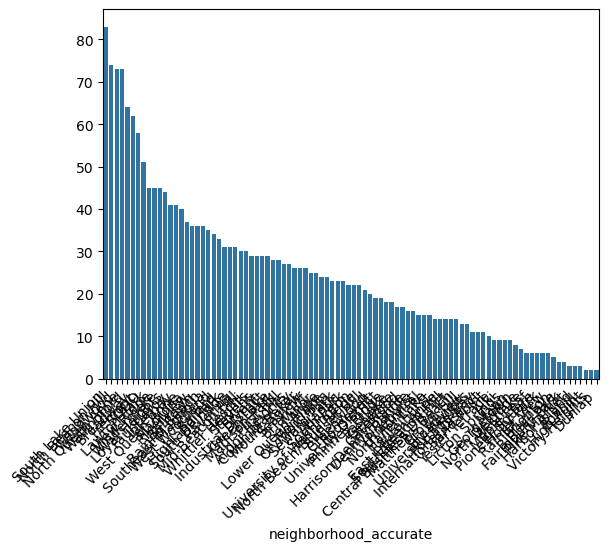

In [53]:
sns.barplot(x = counts.index, y= counts.values);
plt.xticks(rotation=45, ha='right');

In [37]:
# Load the neighborhood boundaries
with open('Neighborhood_Map_Atlas_Neighborhoods.geojson') as f:
    neighborhood_geo = json.load(f)

# Initialize the map centered on the center of your missing data
# (Assuming your columns are 'latitude' and 'longitude')
m = folium.Map(
    location=[df_no_sev['lat'].mean(), df_no_sev['lon'].mean()], 
    zoom_start=11,
    tiles='CartoDB positron' # A clean, light background
)

# Add the GeoJSON Neighborhood Boundaries (Shallow Overlay)
folium.GeoJson(
    neighborhood_geo,
    name='Seattle Neighborhoods',
    style_function=lambda x: {
        'fillColor': 'transparent', 
        'color': 'gray', 
        'weight': 1, 
        'opacity': 0.4
    },
    tooltip=folium.GeoJsonTooltip(fields=['S_HOOD'], aliases=['Neighborhood: '])
).add_to(m)

# Add a HeatMap of the NA values
# This will highlight the "areas" with high concentrations of missing data
heat_data = df_no_sev[['lat', 'lon']].values.tolist()
HeatMap(heat_data, radius=12, blur=15, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)

# Optional: Add a Layer Control to toggle boundaries on/off
folium.LayerControl().add_to(m)

# Display the map directly in the notebook
m

## Using areas where severity data is available: 


In [17]:
# Using areas where severity data is available: 
df_sub = df_final[~df_final['severity'].isna()]


In [18]:
len(df_sub)

79722

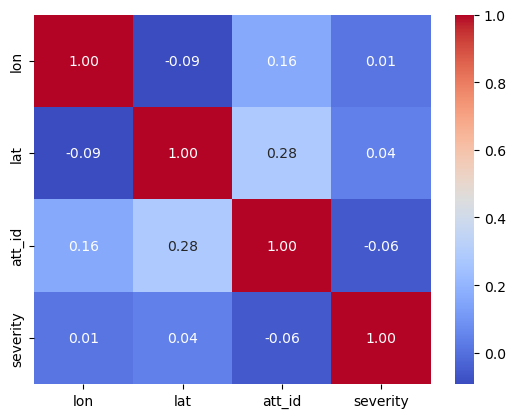

In [19]:
corr = df_sub[['lon','lat','att_id','severity']].corr()
# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

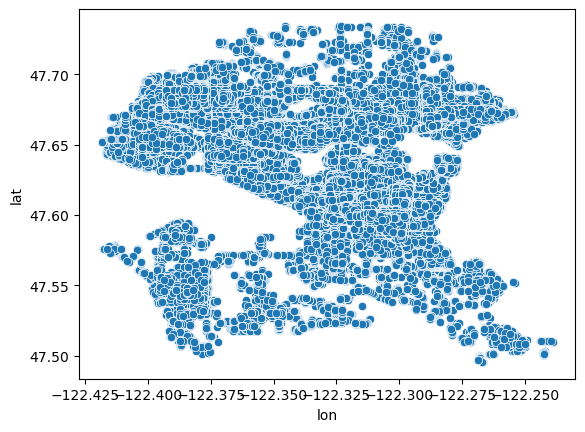

In [20]:
sns.scatterplot(x = 'lon',y = 'lat', data = df_sub);

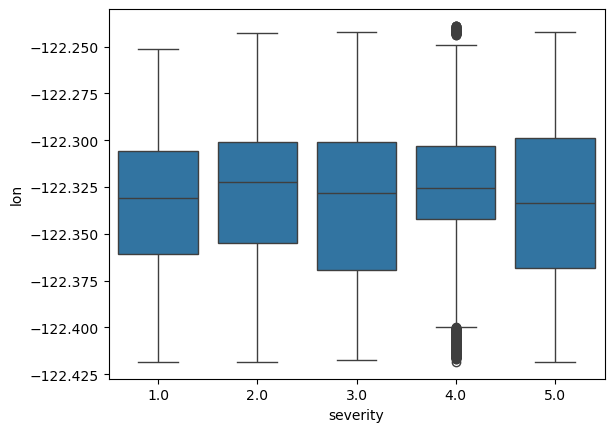

In [21]:
sns.boxplot(x = 'severity', y = 'lon', data = df_sub);

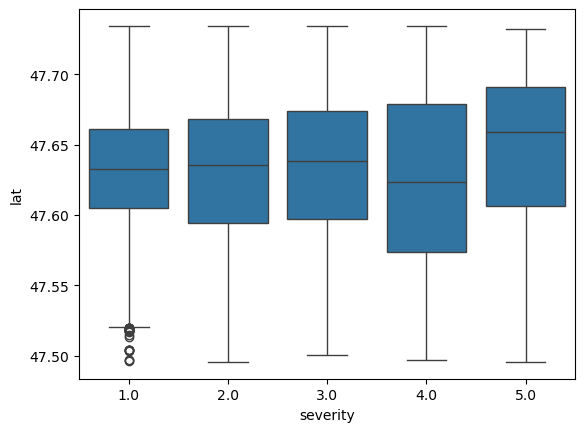

In [22]:
sns.boxplot(x = 'severity', y = 'lat', data = df_sub);

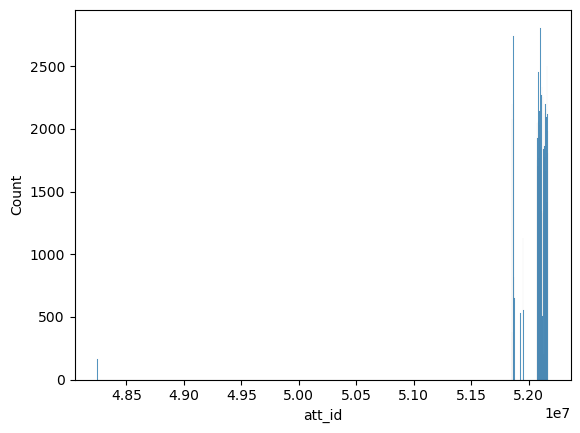

In [23]:
sns.histplot(data = df_sub, x = 'att_id');

In [24]:
mean_severity_across_types = df_sub.groupby('label')['severity'].mean().reset_index()
mean_severity_across_types

label  severity
0        CurbRamp  1.567223
1      NoCurbRamp  3.597906
2      NoSidewalk  3.893777
3        Obstacle  3.098929
4           Other  2.828125
5  SurfaceProblem  2.664796

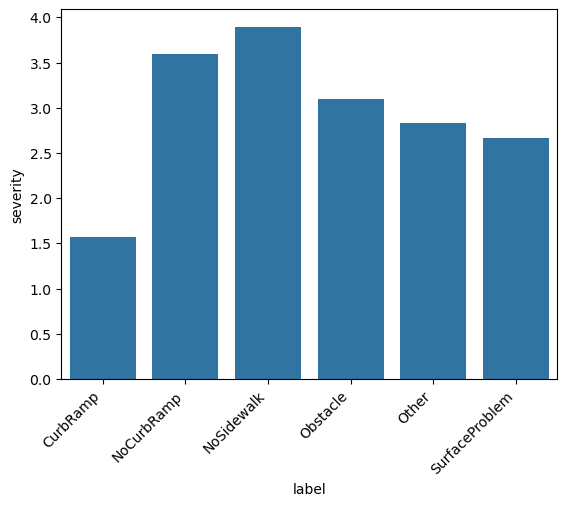

In [25]:
sns.barplot(x= 'label',y = 'severity', data = mean_severity_across_types);
plt.xticks(rotation=45, ha='right');


In [26]:
nh_sev = df_sub.groupby('neighborhood')['severity'].mean().reset_index()
nh_sev

neighborhood  severity
0                       Adams  2.566733
1                    Atlantic  2.361646
2                    Belltown  1.722167
3                  Briarcliff  2.239787
4                    Broadway  2.455732
5                      Bryant  2.794495
6   Central Business District  1.603865
7             East Queen Anne  2.599324
8                    Eastlake  2.485095
9                  First Hill  2.434415
10                    Fremont  2.560000
11                 Green Lake  2.824235
12              Harbor Island  2.976048
13      Harrison/Denny-Blaine  2.773649
14        Industrial District  3.290514
15                   Interbay  3.352349
16     International District  2.077098
17                Laurelhurst  2.272543
18                Lawton Park  2.752537
19                     Leschi  2.771202
20           Lower Queen Anne  2.086768
21              Loyal Heights  2.980957
22               Madison Park  2.735069
23                    Madrona  2.736689
24                       Mann  2.077273
25                      Minor  2.328000
26                   Montlake  2.719626
27                Mount Baker  2.760938
28          North Beacon Hill  2.644444
29           North Queen Anne  2.699150
30              Phinney Ridge  2.842314
31                Pike-Market  1.919708
32             Pioneer Square  1.754221
33                Portage Bay  2.309148
34                    Ravenna  3.417517
35                  Roosevelt  3.075261
36                 Sand Point  3.303371
37           South Lake Union  1.750371
38         Southeast Magnolia  2.642963
39                    Stevens  2.365302
40                Sunset Hill  2.825573
41        University District  2.268280
42                 View Ridge  3.419938
43                Wallingford  3.252496
44            West Queen Anne  2.421606
45              West Woodland  2.255439
46                   Westlake  2.041322
47           Whittier Heights  3.430206
48                 Windermere  2.992320
49             Yesler Terrace  2.846847

In [27]:
nh_sev = nh_sev.sort_values(by = 'severity')
nh_sev

neighborhood  severity
6   Central Business District  1.603865
2                    Belltown  1.722167
37           South Lake Union  1.750371
32             Pioneer Square  1.754221
31                Pike-Market  1.919708
46                   Westlake  2.041322
16     International District  2.077098
24                       Mann  2.077273
20           Lower Queen Anne  2.086768
3                  Briarcliff  2.239787
45              West Woodland  2.255439
41        University District  2.268280
17                Laurelhurst  2.272543
33                Portage Bay  2.309148
25                      Minor  2.328000
1                    Atlantic  2.361646
39                    Stevens  2.365302
44            West Queen Anne  2.421606
9                  First Hill  2.434415
4                    Broadway  2.455732
8                    Eastlake  2.485095
10                    Fremont  2.560000
0                       Adams  2.566733
7             East Queen Anne  2.599324
38         Southeast Magnolia  2.642963
28          North Beacon Hill  2.644444
29           North Queen Anne  2.699150
26                   Montlake  2.719626
22               Madison Park  2.735069
23                    Madrona  2.736689
18                Lawton Park  2.752537
27                Mount Baker  2.760938
19                     Leschi  2.771202
13      Harrison/Denny-Blaine  2.773649
5                      Bryant  2.794495
11                 Green Lake  2.824235
40                Sunset Hill  2.825573
30              Phinney Ridge  2.842314
49             Yesler Terrace  2.846847
12              Harbor Island  2.976048
21              Loyal Heights  2.980957
48                 Windermere  2.992320
35                  Roosevelt  3.075261
43                Wallingford  3.252496
14        Industrial District  3.290514
36                 Sand Point  3.303371
15                   Interbay  3.352349
34                    Ravenna  3.417517
42                 View Ridge  3.419938
47           Whittier Heights  3.430206

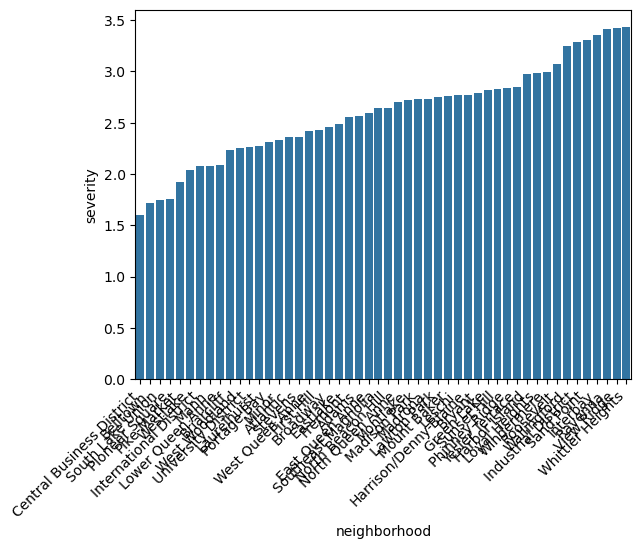

In [28]:
sns.barplot(x= 'neighborhood',y = 'severity', data = nh_sev);
plt.xticks(rotation=45, ha='right');

In [29]:
df_sub['is_temp'].value_counts()

is_temp
False    78998
True       724
Name: count, dtype: int64

In [30]:
temp_map = {False: 0, True: 1}
df_sub['is_temp'] = df_sub['is_temp'].map(temp_map)
df_sub.head()

/var/folders/58/bxfs02q56pzfmzl9zs71htz00000gn/T/ipykernel_5593/2024191319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['is_temp'] = df_sub['is_temp'].map(temp_map)


type geometry/type         lon        lat    att_id           label  \
0  Feature         Point -122.298981  47.594616  52096165  SurfaceProblem   
1  Feature         Point -122.301071  47.593357  52096166  SurfaceProblem   
2  Feature         Point -122.301079  47.596844  52096167  SurfaceProblem   
3  Feature         Point -122.301071  47.596500  52096168  SurfaceProblem   
4  Feature         Point -122.306274  47.599930  52096365      NoCurbRamp   

  neighborhood  severity  is_temp  
0     Atlantic       4.0        0  
1     Atlantic       3.0        0  
2     Atlantic       4.0        0  
3     Atlantic       4.0        0  
4     Atlantic       4.0        0

In [31]:
temp_sev = df_sub.groupby('is_temp')['severity'].mean().reset_index()
temp_sev

is_temp  severity
0        0  2.801843
1        1  3.428177

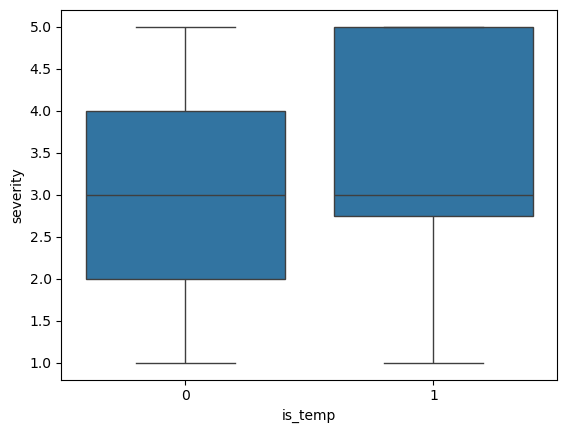

In [32]:
sns.boxplot(x = 'is_temp', y = 'severity', data = df_sub);

In [33]:
label_dist = df_sub.groupby('label')['att_id'].count().reset_index()
label_dist

label  att_id
0        CurbRamp   26732
1      NoCurbRamp   16618
2      NoSidewalk   18593
3        Obstacle    5418
4           Other      64
5  SurfaceProblem   12297

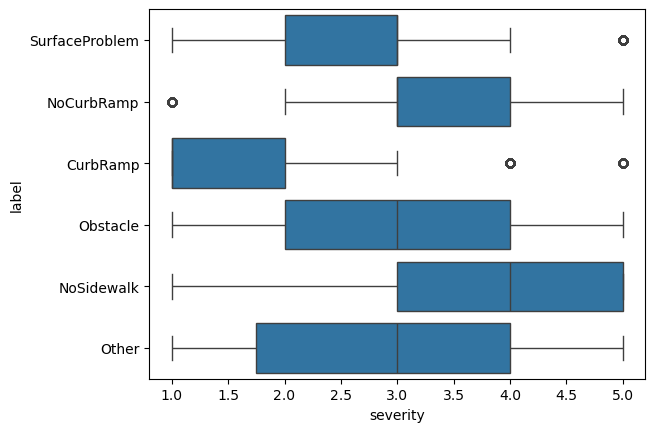

In [34]:
sns.boxplot(x = 'severity', y = 'label', data = df_sub);

Promising predictors: 
- label
- is_temp
- neighborhood (hard to tell)
- lat/lon mapping indicates that different articles are found in different parts of the city.

### Trying to map severity onto lat lon

In [52]:
# # Initialize map
# mean_lat = df_sub['lat'].mean()
# mean_lon = df_sub['lon'].mean()
# m = folium.Map(location=[mean_lat, mean_lon], zoom_start=5)

# heat_data = df_sub[['lat','lon','severity']].values.tolist()

# # Plot
# HeatMap(heat_data, radius=15, blur=10).add_to(m)
# m

Try making severity maps but focused on smaller neighborhoods

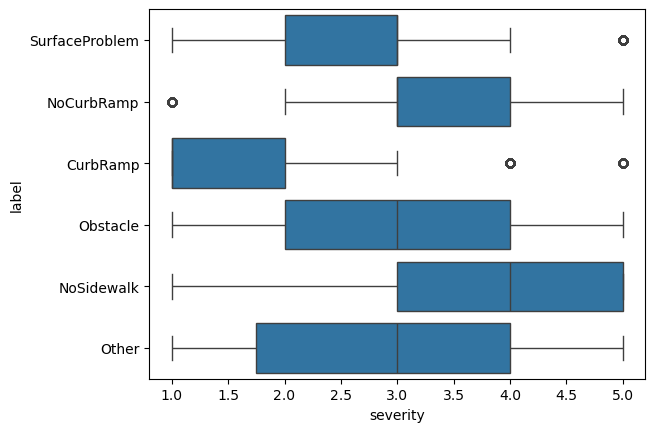

In [39]:
sns.boxplot(x = 'severity', y = 'label', data = df_sub);

Plotting temporary graph visualizating lat, lon, severity, incident type, and neighborhood.

In [41]:
# # 1. Define colors for your 6 incident labels
# label_colors = {
#     'CurbRamp': 'green',
#     'NoCurbRamp': 'red',
#     'NoSidewalk': 'orange',
#     'Obstacle': 'purple',
#     'SurfaceProblem': 'blue',
#     'Other': 'gray'
# }

# # 2. Initialize map
# mean_lat = df_sub['lat'].mean()
# mean_lon = df_sub['lon'].mean()
# m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# # 3. Add Neighborhood Boundaries from GeoJSON
# # Based on your file, we'll use 'S_HOOD' for neighborhood names
# with open('Neighborhood_Map_Atlas_Neighborhoods.geojson') as f:
#     neighborhood_geo = json.load(f)

# folium.GeoJson(
#     neighborhood_geo,
#     name='Neighborhoods',
#     style_function=lambda x: {'fillColor': 'transparent', 'color': 'blue', 'weight': 1},
#     tooltip=folium.GeoJsonTooltip(fields=['S_HOOD'], aliases=['Neighborhood: '])
# ).add_to(m)

# # 4. Add Categorized Incident Markers
# for idx, row in df_sub.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['lon']],
#         radius=6,
#         # Fetch color from dict based on 'label' column
#         color=label_colors.get(row['label'], 'black'),
#         fill=True,
#         fill_opacity=0.7,
#         popup=(
#             f"<b>Neighborhood:</b> {row['neighborhood']}<br>"
#             f"<b>Issue:</b> {row['label']}<br>"
#             f"<b>Severity:</b> {row['severity']}"
#         )
#     ).add_to(m)

# # 5. Display the map in Jupyter
# m

In [48]:
# seattle_neighborhoods = gpd.read_file('Neighborhood_Map_Atlas_Neighborhoods.geojson')

# def gen_plot_by_labeltype(label_type):
#     focus_mask = df["label"] == label_type
#     background = df[~focus_mask]
#     foreground = df[focus_mask]

#     fig, ax = plt.subplots(figsize=(10, 12))

#     # --- NEW: Shallow overlay of GeoJSON Boundaries ---
#     # Plotting this first ensures it is behind all labels and points
#     seattle_neighborhoods.plot(
#         ax=ax, 
#         color='whitesmoke',   # Shallow/light background color
#         edgecolor='gray',      # Subtle boundaries
#         linewidth=0.5, 
#         alpha=0.3,
#         zorder=1               # Lowest layer
#     )

#     # Plot background points
#     ax.scatter(
#         background["lon"],
#         background["lat"],
#         s=4,
#         color="lightsteelblue",
#         alpha=0.4,
#         label="background",
#         zorder=2
#     )

#     # Plot focused foreground points
#     ax.scatter(
#         foreground["lon"],
#         foreground["lat"],
#         s=6,
#         color="darkred",
#         alpha=0.8,
#         label=label_type,
#         zorder=3
#     )

#     # Grouping and Hull logic (as per your original code)
#     for name, chunk in df.groupby("neighborhood"):
#         if len(chunk) < 5:
#             continue
#         hull = MultiPoint(chunk[["lon", "lat"]].values)
#         if hull.is_empty:
#             continue
#         hull = hull.convex_hull
        
#         # Plotting hulls and labels on top (zorder 4)
#         if hull.geom_type == "Polygon":
#             x, y = hull.exterior.xy
#             ax.fill(x, y, alpha=0.1, color='blue', zorder=4)
#         elif hull.geom_type == "LineString":
#             x, y = hull.xy
#             ax.plot(x, y, alpha=0.5, zorder=4)
        
#         centroid = hull.centroid
#         ax.text(
#             centroid.x,
#             centroid.y,
#             name,
#             fontsize=7,
#             ha="center",
#             va="center",
#             zorder=5,
#             bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.7, "edgecolor": "none", "pad": 0.2},
#         )

#     ax.set_aspect("equal", adjustable="box")
#     ax.set_xlabel("lon")
#     ax.set_ylabel("lat")
#     plt.title(f"{label_type} across Seattle")
#     plt.tight_layout()
#     plt.show()


In [70]:
# 1. Load the Neighborhood GeoJSON
# This file uses the CRS84 coordinate system (Lon/Lat)
neighborhoods_gdf = gpd.read_file('Neighborhood_Map_Atlas_Neighborhoods.geojson')

# 2. Convert your DataFrame to a GeoDataFrame
# Assuming 'longitude' and 'latitude' are your column names
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
incidents_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 3. Spatial Join: Assign official neighborhood names (S_HOOD) to each incident
# This replaces your old 'properties/neighborhood' column with official data
incidents_gdf = gpd.sjoin(incidents_gdf, neighborhoods_gdf[['S_HOOD', 'geometry']], how='left', predicate='intersects')

def gen_plot_by_labeltype(label_type):
    # Filter using the new GeoDataFrame
    focus_mask = incidents_gdf["label"] == label_type
    background = incidents_gdf[~focus_mask]
    foreground = incidents_gdf[focus_mask]

    fig, ax = plt.subplots(figsize=(12, 10))

    # --- Overlay official GeoJSON Boundaries first (Background) ---
    neighborhoods_gdf.plot(
        ax=ax, 
        color='whitesmoke', 
        edgecolor='lightgray', 
        linewidth=0.5, 
        alpha=0.5,
        zorder=1
    )

    # Plot points
    ax.scatter(background["lon"], background["lat"], s=4, color="lightsteelblue", alpha=0.4, zorder=2)
    ax.scatter(foreground["lon"], foreground["lat"], s=6, color="darkred", alpha=0.8, zorder=3)

    # --- Use 'S_HOOD' for grouping (Official Atlas Neighborhoods) ---
    for name, chunk in incidents_gdf.groupby("S_HOOD"):
        if len(chunk) < 5 or pd.isna(name):
            continue
        
        hull = MultiPoint(chunk[["lon", "lat"]].values)
        if hull.is_empty:
            continue
        hull = hull.convex_hull
        
        if hull.geom_type == "Polygon":
            x, y = hull.exterior.xy
            ax.fill(x, y, alpha=0.15, color='blue', zorder=4)
        
        centroid = hull.centroid
        ax.text(
            centroid.x, centroid.y, name,
            fontsize=7, ha="center", va="center", zorder=5,
            bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.7, "edgecolor": "none", "pad": 0.2}
        )

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title(f"{label_type} incidents mapped to Atlas Neighborhoods")
    plt.tight_layout()

    file_name = f"seattle_map_{label_type}.png"
    plt.savefig(file_name, dpi = 300, bbox_inches = 'tight')
    print(f"Saved: {file_name}")
    
    plt.show()

Saved: seattle_map_SurfaceProblem.png


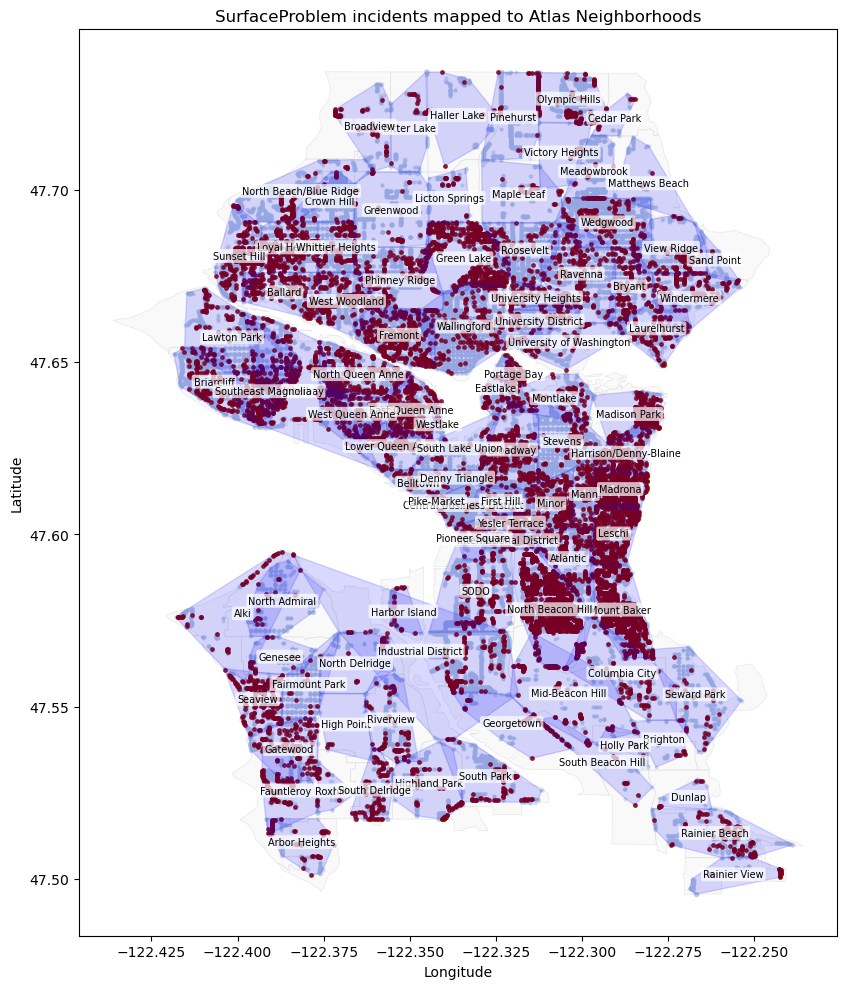

Saved: seattle_map_CurbRamp.png


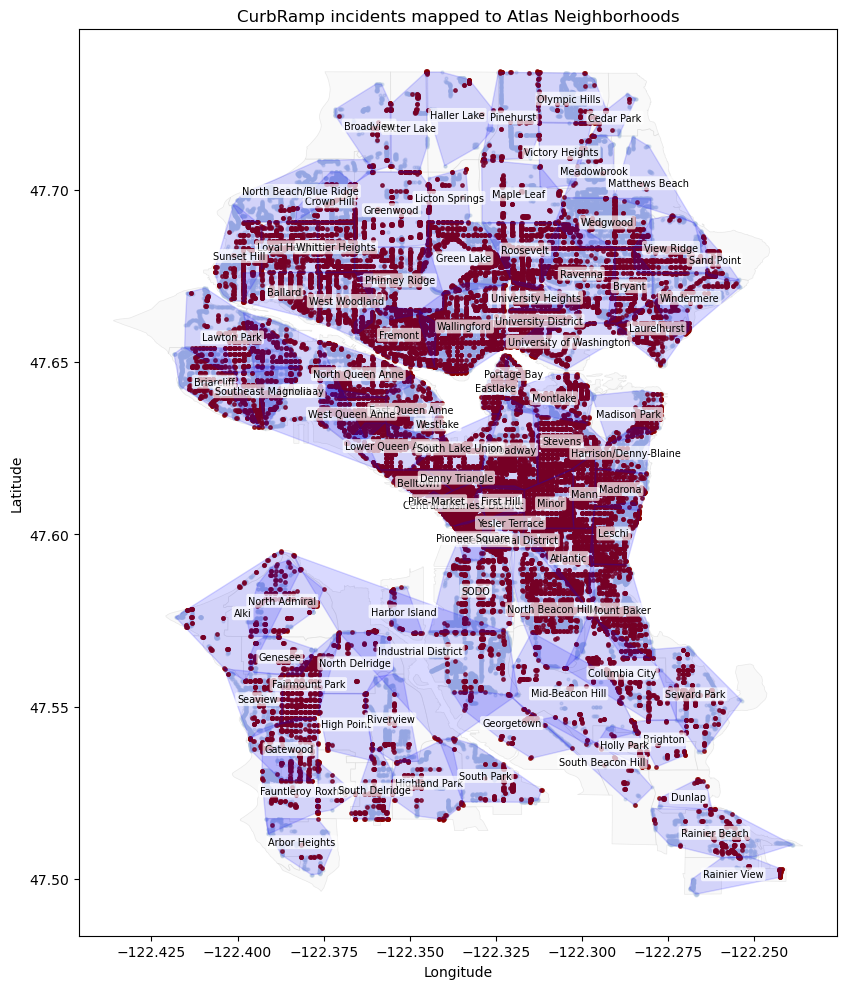

Saved: seattle_map_NoCurbRamp.png


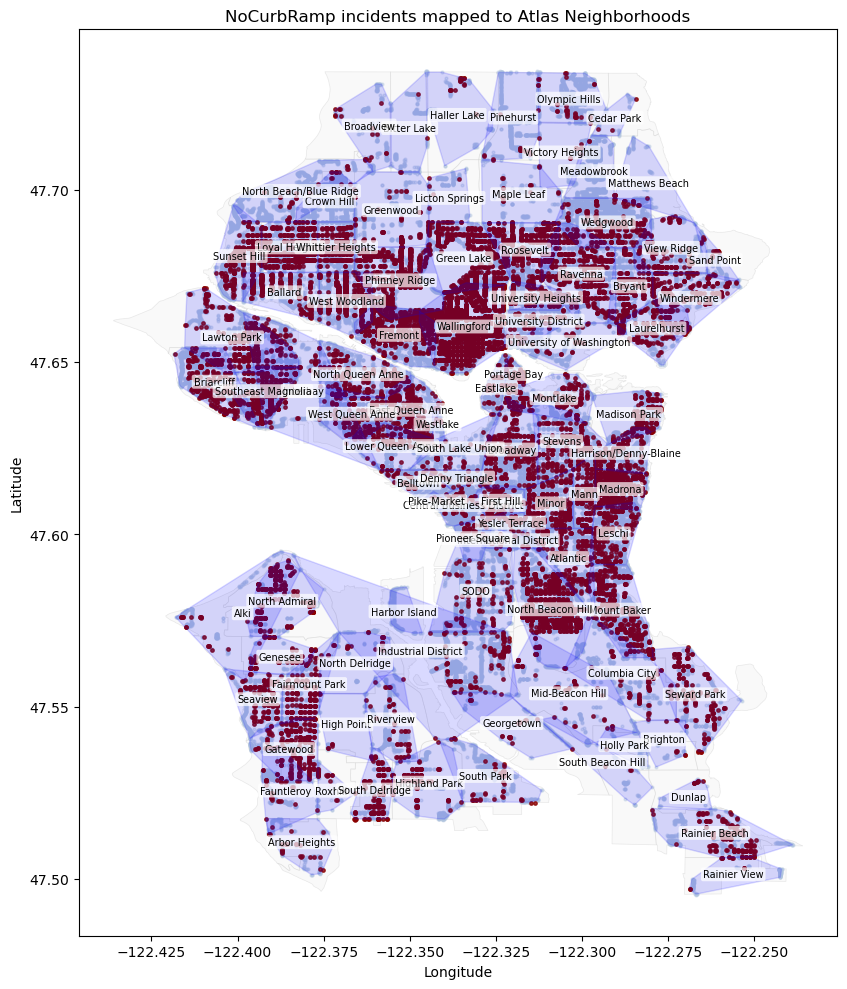

Saved: seattle_map_Obstacle.png


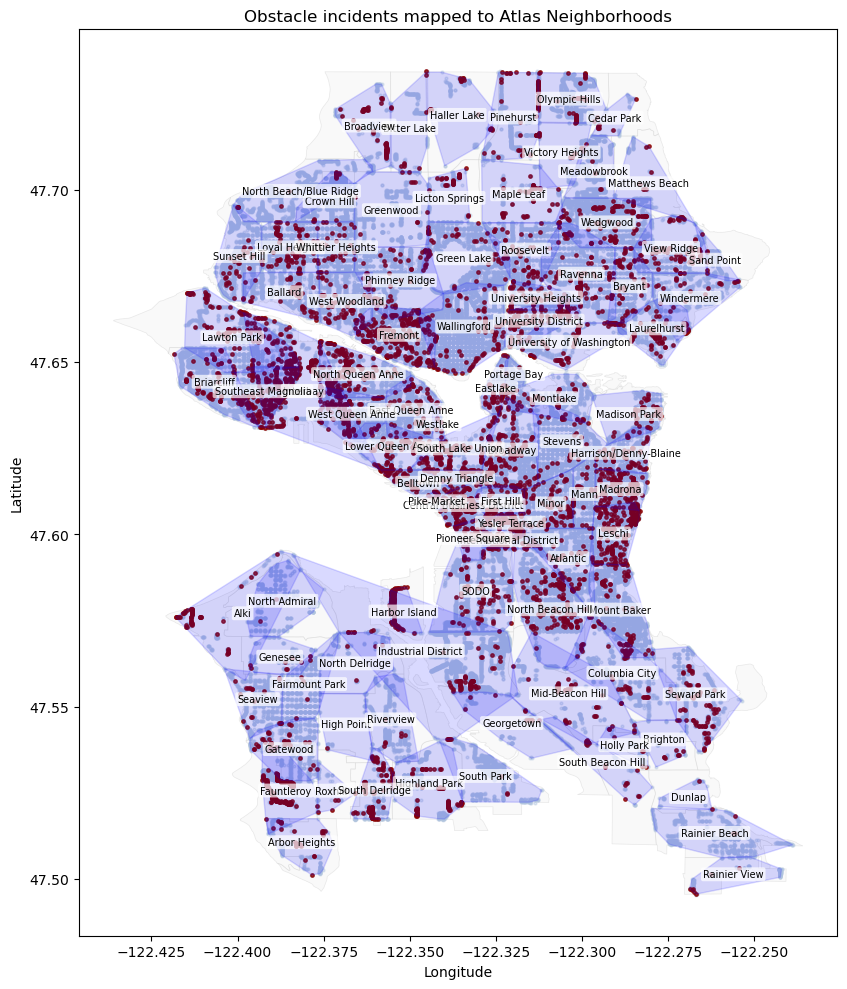

Saved: seattle_map_NoSidewalk.png


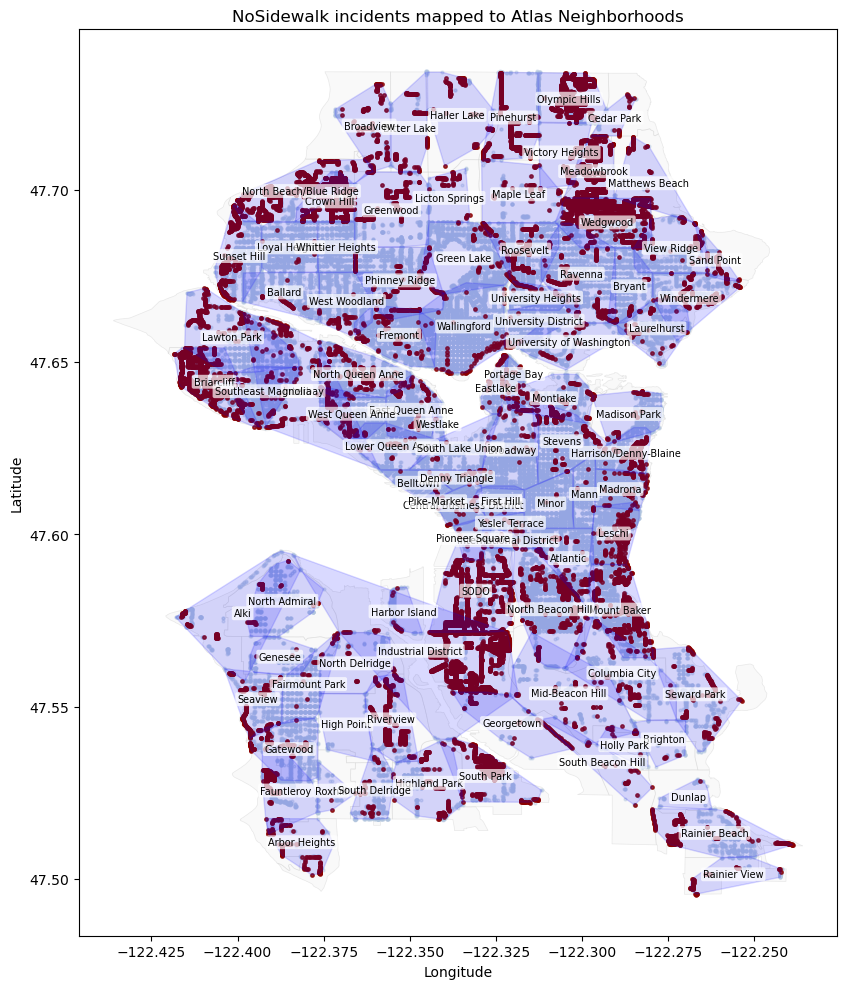

Saved: seattle_map_Other.png


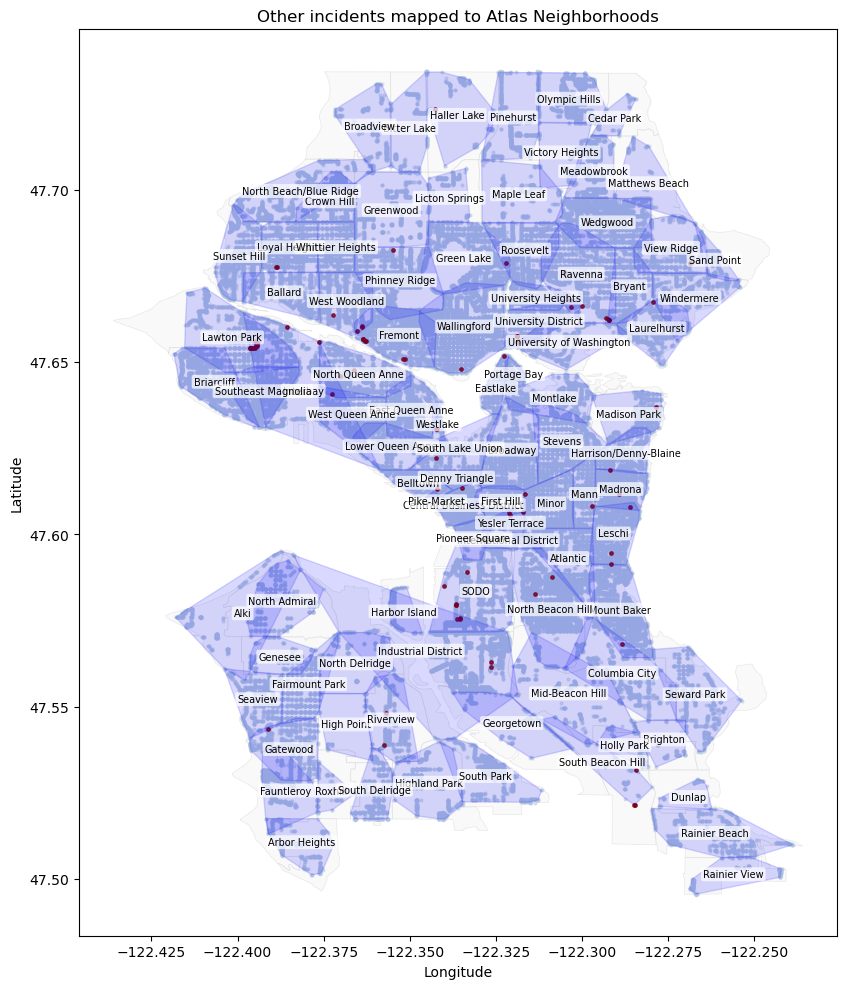

In [71]:
# Run the generator
for label in ["SurfaceProblem", "CurbRamp", "NoCurbRamp", "Obstacle", "NoSidewalk","Other"]:
    gen_plot_by_labeltype(label)